## Install Libraries

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Load Data

In [3]:
import gdown

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=a1973df8-a235-4db8-a2fb-902126b55311
To: C:\Users\Vedan\OneDrive\Desktop\My Courses\EE-AAI 627\lipreading\data.zip
100%|███████████████████████████████████████████████████████████████████████████████| 423M/423M [00:11<00:00, 37.6MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [2]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) #slicing the mouth region
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))#scaling the image
    return tf.cast((frames - mean), tf.float32) / std

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [4]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") #takes a char and converts to num
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
) #opposite of char to num

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [5]:
char_to_num(['v','e','d','a','n','t'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([22,  5,  4,  1, 14, 20], dtype=int64)>

In [6]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':   #if alignment contains line sil it means silence hence we nee to ignore
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [7]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [8]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [9]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [10]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [11]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [12]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.19734783],
         [ 0.07893913]],

        [[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209044 ],
         [ 1.4209044 ],
         [ 1.3814349 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.946331  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.86739

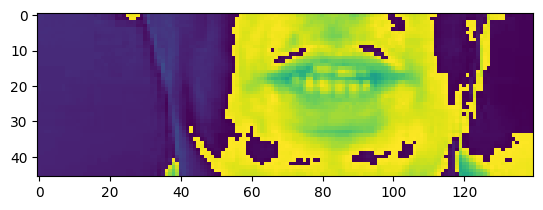

In [13]:
plt.imshow(frames[40]) # we can see the persons mouth

In [14]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Create DataPipeline

In [15]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg') #grab all files ending with mpg
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [25]:
train.as_numpy_iterator().next()[1].shape

(2, 40)

In [16]:
frames, alignments = data.as_numpy_iterator().next()

In [17]:
sample = data.as_numpy_iterator()

In [18]:
val = sample.next(); val[0]

array([[[[[ 1.5127573 ],
          [ 1.5487753 ],
          [ 1.3326671 ],
          ...,
          [ 0.39619833],
          [ 0.43221638],
          [ 0.43221638]],

         [[ 1.5487753 ],
          [ 1.5487753 ],
          [ 1.2606311 ],
          ...,
          [ 0.39619833],
          [ 0.43221638],
          [ 0.43221638]],

         [[ 1.5127573 ],
          [ 1.5127573 ],
          [ 1.4767393 ],
          ...,
          [ 0.36018032],
          [ 0.36018032],
          [ 0.36018032]],

         ...,

         [[ 1.152577  ],
          [ 1.1165589 ],
          [ 1.1165589 ],
          ...,
          [ 0.14407213],
          [ 0.14407213],
          [ 0.14407213]],

         [[ 1.0805409 ],
          [ 1.0805409 ],
          [ 1.0805409 ],
          ...,
          [ 0.14407213],
          [ 0.14407213],
          [ 0.14407213]],

         [[ 1.0805409 ],
          [ 1.0805409 ],
          [ 1.0805409 ],
          ...,
          [ 0.14407213],
          [ 0.14407213],
          

In [31]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.952702522277832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

In [32]:
#the above animation is what our lipnet model is going to decode

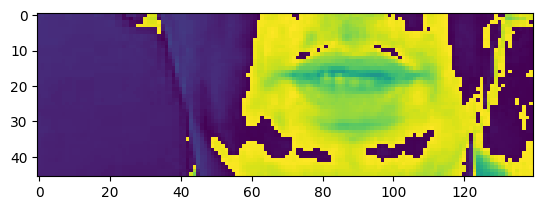

In [21]:
# 0:videos, 0: 1st video out of the batch,  35: return the 35-first frame in the video 
plt.imshow(val[0][0][35])

In [22]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green by r two please'>

## Design Deep Neural Network

In [19]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [20]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [21]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

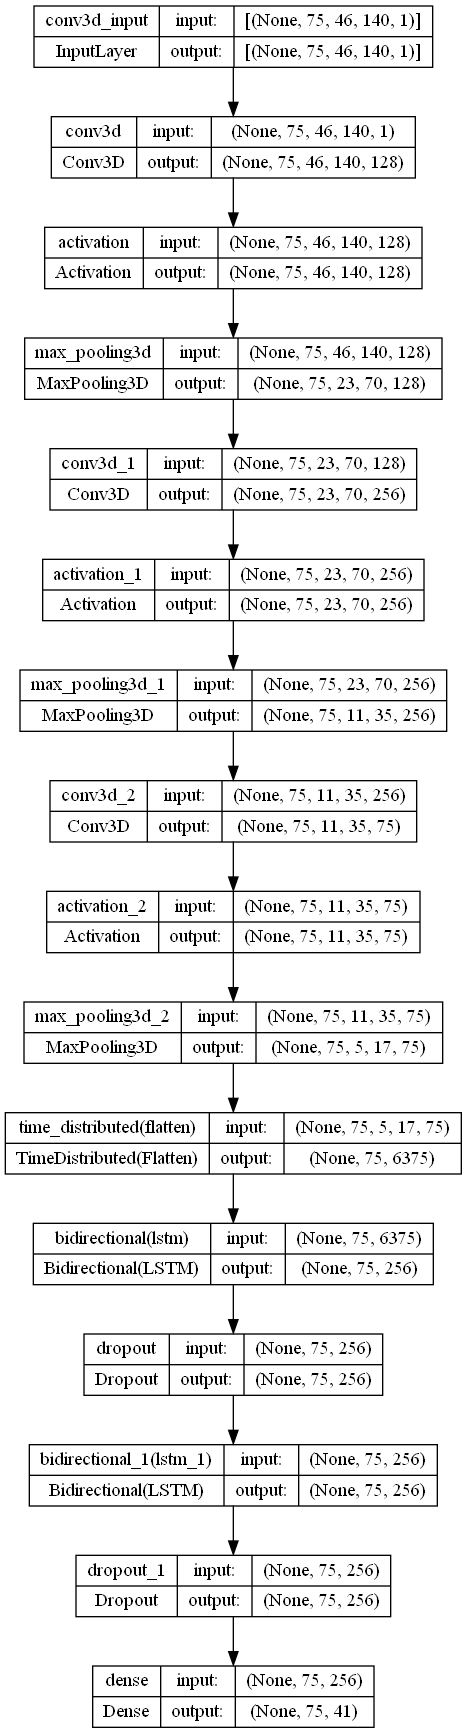

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [24]:
yhat = model.predict(val[0])

1/1 [==============================] - 10s 10s/step


## Setup Training Options

In [25]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [26]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [27]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [29]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [30]:
schedule_callback = LearningRateScheduler(scheduler)

In [31]:
example_callback = ProduceExample(test)

In [33]:
tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 10})

device_count {
  key: "CPU"
  value: 10
}
device_count {
  key: "GPU"
  value: 1
}

In [86]:
with tf.device('/cpu:0'):
    model.fit(train,validation_data=test,epochs=10,batch_size=16)

Epoch 1/10
 20/450 [>.............................] - ETA: 2:57:36 - loss: 2.2976

KeyboardInterrupt: 

## Load Trained Model and make prediction

In [37]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=c2052872-e9f8-4ab0-bfd8-cb757671a83c
To: C:\Users\Vedan\OneDrive\Desktop\My Courses\EE-AAI 627\lipreading\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:02<00:00, 37.5MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [32]:
model.load_weights('models/checkpoint')

In [38]:
test_data = test.as_numpy_iterator()

In [61]:
model.evaluate(test)

50/50 [==============================] - 132s 408ms/step - loss: 1.1237


1.1237040758132935

In [39]:
sample = test_data.next()

In [42]:
yhat = model.predict(sample[0])

1/1 [==============================] - 12s 12s/step


In [42]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white at r seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white with b one again'>]

In [43]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [44]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white at r seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white with b one again'>]

## Test on Video

In [43]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\sgbj3a.mpg'))

In [44]:
print('~'*100, 'REAL TEXT')
real_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
print(real_text[0].numpy().decode('utf-8'))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
set green by j three again


In [45]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [46]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [47]:
print('~'*100, 'PREDICTIONS')
output = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
print(output[0].numpy().decode('utf-8'))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
set green by j three again
